In [1]:
import copy
import pickle
import numpy as np
import networkx as nx
from feature import extract_node_feature, extract_edge_feature

In [2]:
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
from sklearn import metrics

In [3]:
# parameters
classify_epoch = 8
classify_lr = 0.001
thres = 0.5

## Read data

In [4]:
%store -r all_x
%store -r all_y
%store -r test_x

## extract feature

In [5]:
%store -r all_f
%store -r test_f

all_f = all_f.astype('float32')
test_f = test_f.astype('float32')

#all_f = all_f[:, :263]
#test_f = test_f[:, :263]

## training

In [6]:
train_loader2 = DataLoader(
        dataset=TensorDataset(
            torch.from_numpy(all_x[:, 0]),
            torch.from_numpy(all_x[:, 1]),
            torch.from_numpy(all_y),
            torch.from_numpy(all_f)
        ),
        batch_size=512,
        shuffle=True,
        num_workers=8)

x1_test_ = torch.from_numpy(test_x[:, 0]).cuda()
x2_test_ = torch.from_numpy(test_x[:, 1]).cuda()
feat_test = torch.from_numpy(test_f).cuda()

In [7]:
class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        self.fc1 = nn.Linear(feat_test.size()[1], 32)
        self.fc3 = nn.Linear(32, 32)
        self.fc4 = nn.Linear(32, 32)
        self.fc2 = nn.Linear(32, 1)
        
    def forward(self, feat):
        out = F.relu(self.fc1(feat))
        out = F.relu(self.fc3(out))
        out = F.relu(self.fc4(out))
        out = F.sigmoid(self.fc2(out))
        return out

In [8]:
classifier = Classifier().cuda()
optimizer2 = torch.optim.Adam(classifier.parameters(), lr=classify_lr/10, weight_decay=0.01, amsgrad=True)

for epoch in range(100):
    print('Epoch:', epoch)
    
    total_loss = []
    correct = 0
    cnt = 0
    one = 0
    for e , (head, tail, label, feat) in enumerate(train_loader2):
        head, tail, label, feat = head.cuda(), tail.cuda(), label.cuda(), feat.cuda()
        output = classifier(head, tail, feat).squeeze()
        loss = F.binary_cross_entropy(output, label, size_average=False)
        total_loss.append(loss.item())
        
        optimizer2.zero_grad()
        loss.backward()
        optimizer2.step()
        
        cnt += output.size()[0]
        output[output>0.5] = 1
        output[output<0.5] = 0
        correct += (output.squeeze() == label.squeeze()).sum().item()
        one += output.squeeze().sum().item()
    
    
    pred = classifier(x1_test_, x2_test_, feat_test)
    p = pred.detach().cpu().numpy().flatten()
    thres = 0.5
    p[p > thres] = 1
    p[p < thres] = 0
    print('train_loss:{:.4f}, train_acc:{:4f}%'.format(np.mean(total_loss), correct/cnt))
    print('{:4f}, {:.4f}'.format(one/cnt, pred.data.cpu().numpy().sum()/len(pred)))
    torch.save({'state_dict': classifier.state_dict()}, 'classifier.pt')

NameError: name 'f' is not defined

In [11]:
pred = classifier(x1_test_, x2_test_, feat_test)
p = pred.detach().cpu().numpy().flatten()
thres = 0.98
p[p > thres] = 1
p[p < thres] = 0
print(p.sum(), len(p), p.sum()/len(p))

38604.0 88074 0.4383132365964984


In [17]:
%store -r GG
cnt = 0
for i, j in zip(p, test_x):
    if j[0] not in GG or j[1] not in GG:
        p[cnt] = 1
    cnt += 1
print(p.sum()/len(p))

0.442582373912846


In [14]:
from xgboost import XGBRegressor
model = XGBRegressor(n_estimators=150, learning_rate=0.1, max_depth=10)

/home/dada/.local/lib/python3.5/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [15]:
model.fit(all_f, all_y, verbose=True)

XGBRegressor(base_score=0.5, colsample_bylevel=1, colsample_bytree=1, gamma=0,
       learning_rate=0.1, max_delta_step=0, max_depth=10,
       min_child_weight=1, missing=None, n_estimators=150, nthread=-1,
       objective='reg:linear', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)

In [ ]:
pred = model.predict(test_f)
p = pred.copy()
thres = 0.95
p[p > thres] = 1
p[p < thres] = 0
print(p.sum(), len(p), p.sum()/len(p))

In [18]:
with open('pred.txt', 'w') as f:
    for i in p.astype(int):
        print(i, file=f)
!python3 pred-txt-to-csv.py pred.txt

In [ ]:
import pandas as pd
results = pd.read_csv('results.csv')
param = pd.read_csv('param.csv')

#results[len(results.columns)] = p
#param[len(param.columns)] = paras

In [ ]:
print(results['0'].values.sum())
print(p.sum())
print((results['0'].values != p).sum())

In [4]:
data = data[:478709]
label = label[:478709]
split = int(len(data)*0.95)
train = data[:split]
val = data[split:]
G_train = nx.read_edgelist('t1-train.txt', create_using=nx.DiGraph(), nodetype=int, edgetype=int)
unG_train = nx.read_edgelist('t1-train.txt', create_using=nx.Graph(), nodetype=int, edgetype=int)

In [163]:
%store -r data2
%store -r label2
feat = []
for i, j in zip(data2, label2):
    if j == 1:
        continue
    try:
        l = nx.shortest_path_length(GG, i[0], i[1])
    except KeyboardInterrupt:
        raise
    except:
        l = -3
    try:
        ll = nx.shortest_path_length(unGG, i[0], i[1])
    except KeyboardInterrupt:
        raise
    except:
        ll = -3
    feat.append([l, ll])

In [164]:
df_val = pd.DataFrame()

df_val['direct'] = np.array(feat)[:, 0]
df_val['undirect'] = np.array(feat)[:, 1]

In [94]:
feat = []
for i in G_test.edges:
    try:
        l = nx.shortest_path_length(GG, i[0], i[1])
    except:
        l = -3
    try:
        ll = nx.shortest_path_length(unGG, i[0], i[1])
    except:
        ll = -3
    feat.append([l, ll])

test_f = feat

In [95]:
import pandas as pd
df = pd.DataFrame()
test_f = np.array(test_f)
df['direct'] = test_f[:, 0]
df['undirect'] = test_f[:, 1]

In [158]:
a = set()
tmp = [2]
for _ in range(4):
    new = set()
    for i in tmp:
        new = new | set(GG.successors(i))
    new = new - a
    a = a | new
    tmp = new
a = a - set(GG.successors(2))
len(a)

2995

In [161]:
nx.shortest_path_length(GG, 2, 29)

4

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fb5037ed630>,
      dtype=object)

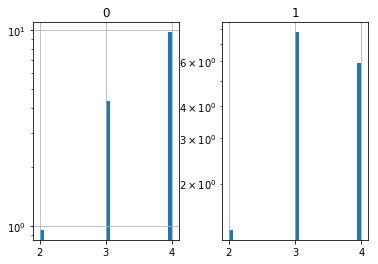

In [160]:
b = np.random.choice(list(a), 500)
df_ = pd.DataFrame()
c = []
for i in b:
    try:
        c.append(nx.shortest_path_length(GG, 2, i))
    except:
        c.append(-3)
df_[0] = c
df_[1] = [nx.shortest_path_length(unGG, 2, i) for i in b]

df_.hist(density=True, log=True, bins=30)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fb5007ddeb8>,
      dtype=object)

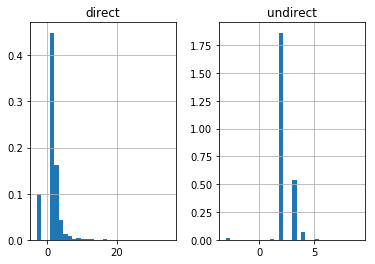

In [166]:
%matplotlib inline
df.hist(density=True, bins=30)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fb4fdec19b0>,
      dtype=object)

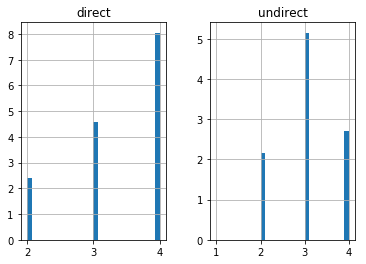

In [167]:
df_val.hist(density=True, bins=30)

/home/dada/.local/lib/python3.5/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


direct
-3     [[AxesSubplot(0.125,0.125;0.775x0.755)]]
 0     [[AxesSubplot(0.125,0.125;0.775x0.755)]]
 2     [[AxesSubplot(0.125,0.125;0.775x0.755)]]
 3     [[AxesSubplot(0.125,0.125;0.775x0.755)]]
 4     [[AxesSubplot(0.125,0.125;0.775x0.755)]]
 5     [[AxesSubplot(0.125,0.125;0.775x0.755)]]
 6     [[AxesSubplot(0.125,0.125;0.775x0.755)]]
 7     [[AxesSubplot(0.125,0.125;0.775x0.755)]]
 8     [[AxesSubplot(0.125,0.125;0.775x0.755)]]
 9     [[AxesSubplot(0.125,0.125;0.775x0.755)]]
 10    [[AxesSubplot(0.125,0.125;0.775x0.755)]]
 11    [[AxesSubplot(0.125,0.125;0.775x0.755)]]
 12    [[AxesSubplot(0.125,0.125;0.775x0.755)]]
 13    [[AxesSubplot(0.125,0.125;0.775x0.755)]]
 14    [[AxesSubplot(0.125,0.125;0.775x0.755)]]
 15    [[AxesSubplot(0.125,0.125;0.775x0.755)]]
 16    [[AxesSubplot(0.125,0.125;0.775x0.755)]]
 17    [[AxesSubplot(0.125,0.125;0.775x0.755)]]
 18    [[AxesSubplot(0.125,0.125;0.775x0.755)]]
 19    [[AxesSubplot(0.125,0.125;0.775x0.755)]]
 20    [[AxesSubplot(0.125,0.125;

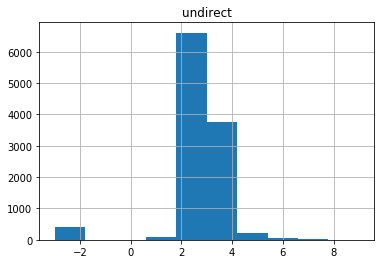

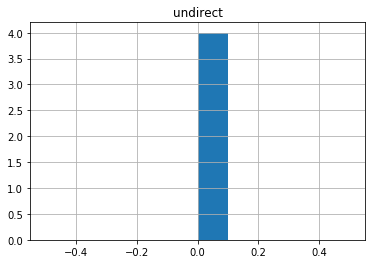

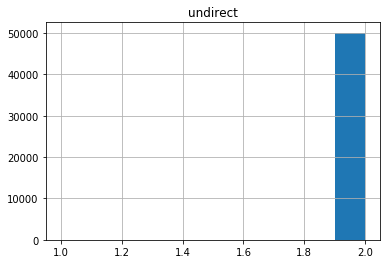

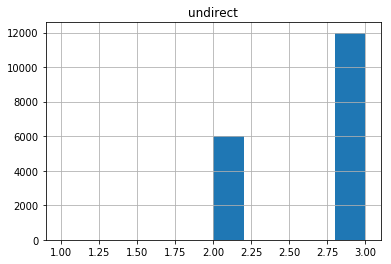

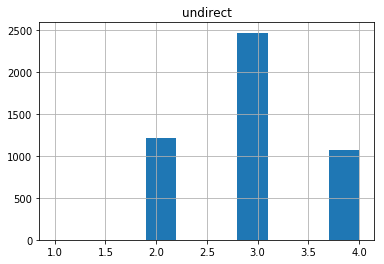

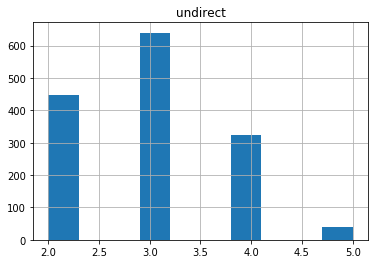

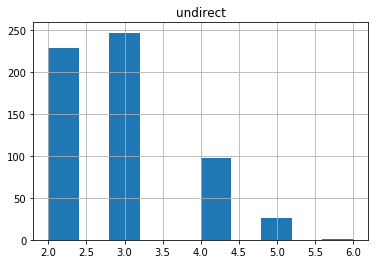

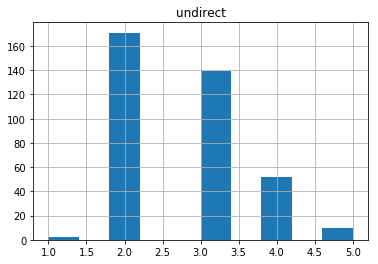

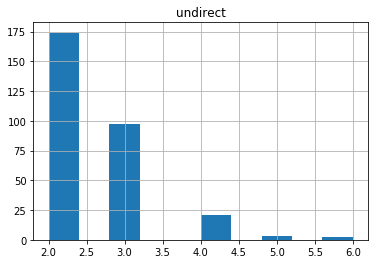

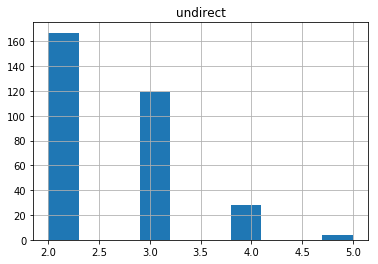

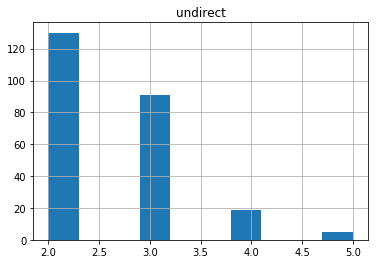

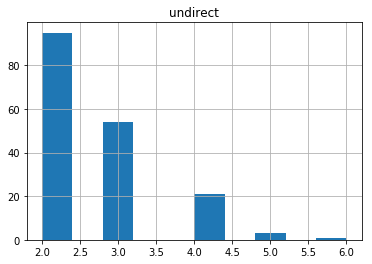

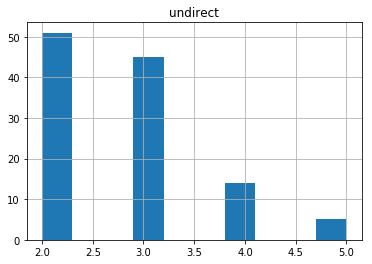

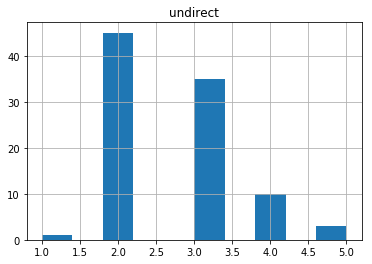

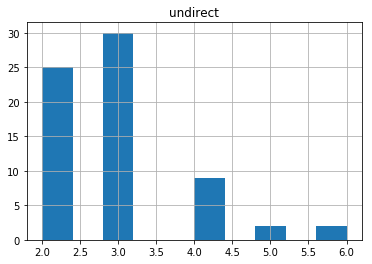

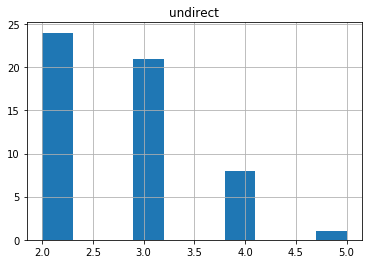

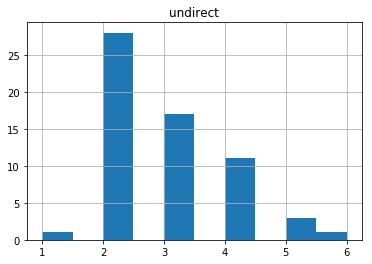

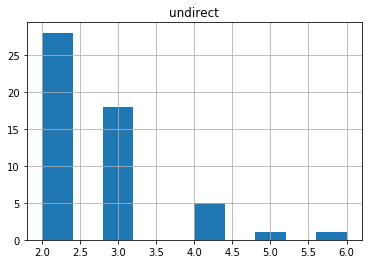

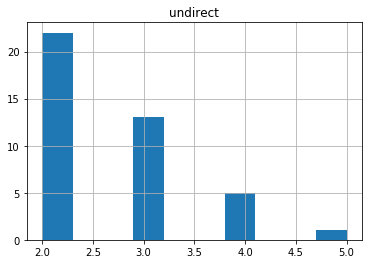

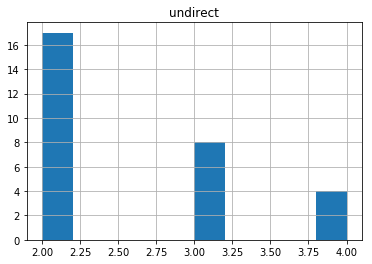

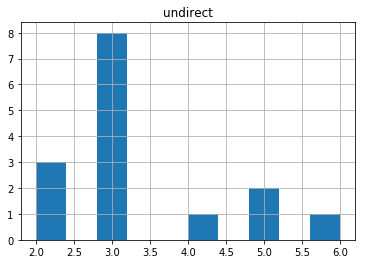

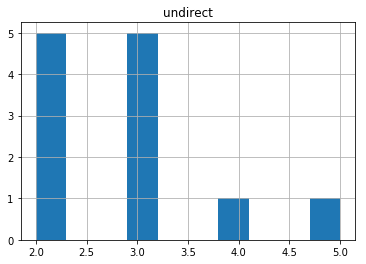

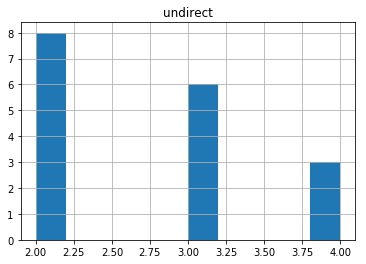

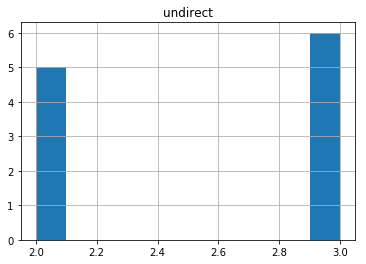

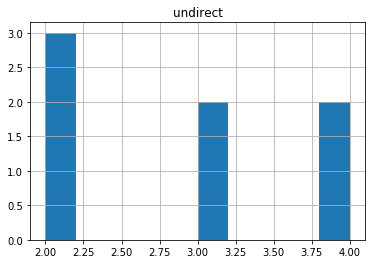

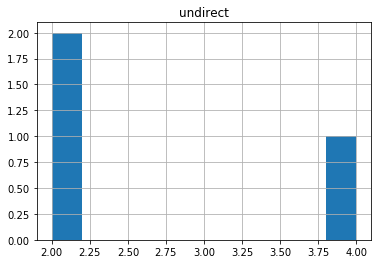

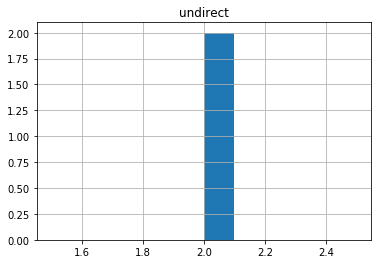

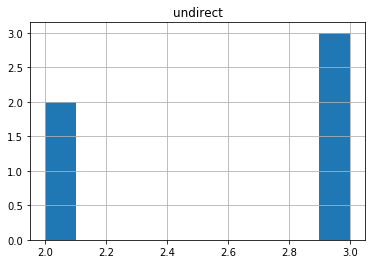

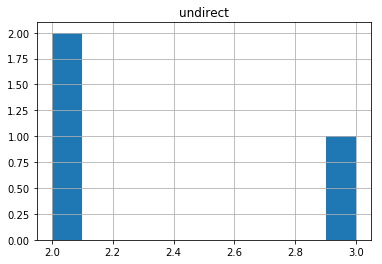

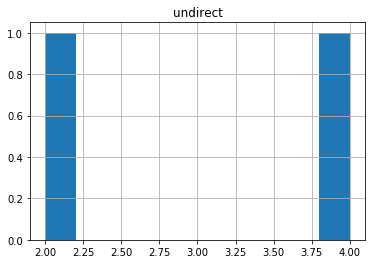

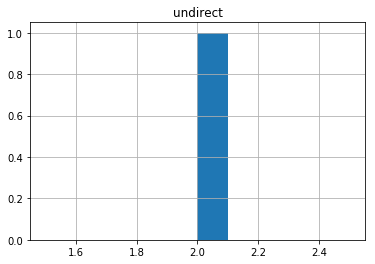

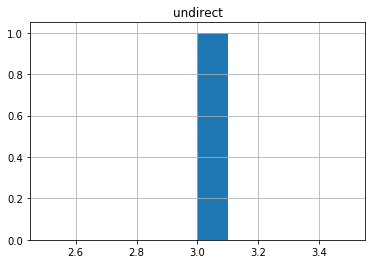

In [97]:
df.groupby('direct').hist()

undirect
-3    [[AxesSubplot(0.125,0.125;0.775x0.755)]]
 0    [[AxesSubplot(0.125,0.125;0.775x0.755)]]
 1    [[AxesSubplot(0.125,0.125;0.775x0.755)]]
 2    [[AxesSubplot(0.125,0.125;0.775x0.755)]]
 3    [[AxesSubplot(0.125,0.125;0.775x0.755)]]
 4    [[AxesSubplot(0.125,0.125;0.775x0.755)]]
 5    [[AxesSubplot(0.125,0.125;0.775x0.755)]]
 6    [[AxesSubplot(0.125,0.125;0.775x0.755)]]
 7    [[AxesSubplot(0.125,0.125;0.775x0.755)]]
 8    [[AxesSubplot(0.125,0.125;0.775x0.755)]]
 9    [[AxesSubplot(0.125,0.125;0.775x0.755)]]
dtype: object

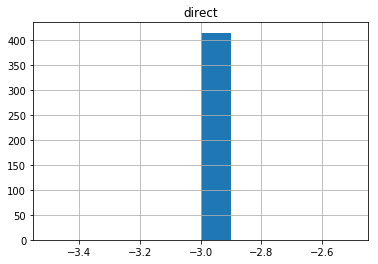

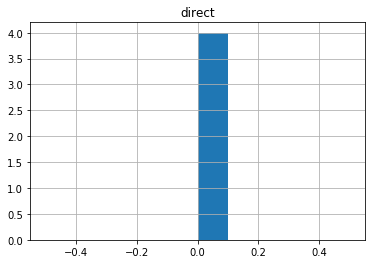

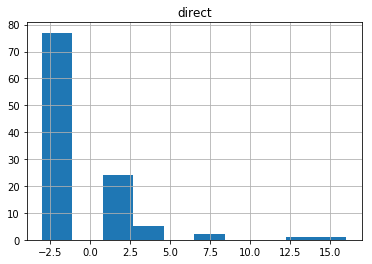

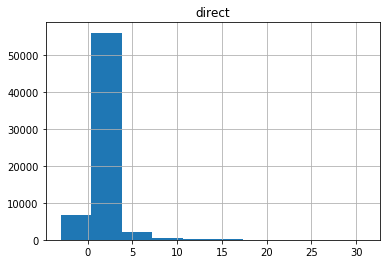

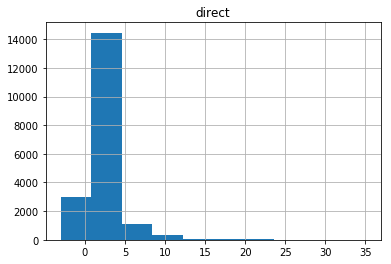

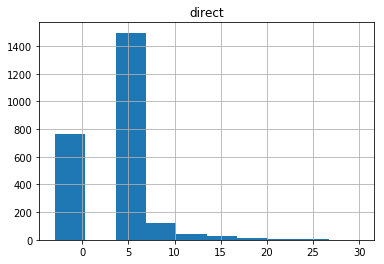

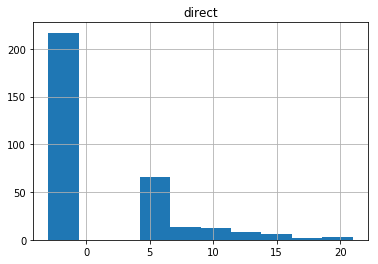

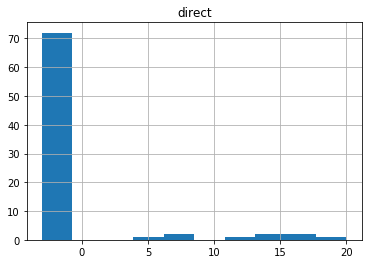

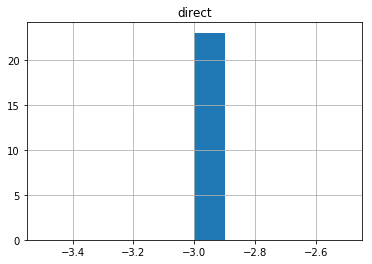

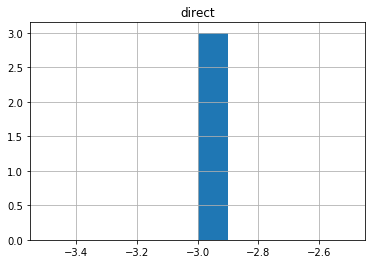

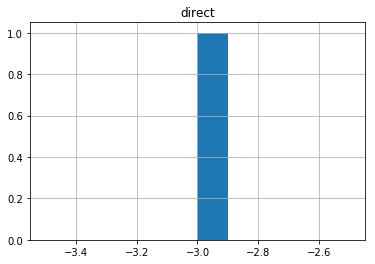

In [105]:
df.groupby('undirect').hist()

/home/dada/.local/lib/python3.5/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


direct
-3     [[AxesSubplot(0.125,0.125;0.775x0.755)]]
 2     [[AxesSubplot(0.125,0.125;0.775x0.755)]]
 3     [[AxesSubplot(0.125,0.125;0.775x0.755)]]
 4     [[AxesSubplot(0.125,0.125;0.775x0.755)]]
 5     [[AxesSubplot(0.125,0.125;0.775x0.755)]]
 6     [[AxesSubplot(0.125,0.125;0.775x0.755)]]
 7     [[AxesSubplot(0.125,0.125;0.775x0.755)]]
 8     [[AxesSubplot(0.125,0.125;0.775x0.755)]]
 9     [[AxesSubplot(0.125,0.125;0.775x0.755)]]
 10    [[AxesSubplot(0.125,0.125;0.775x0.755)]]
 11    [[AxesSubplot(0.125,0.125;0.775x0.755)]]
 12    [[AxesSubplot(0.125,0.125;0.775x0.755)]]
 13    [[AxesSubplot(0.125,0.125;0.775x0.755)]]
 14    [[AxesSubplot(0.125,0.125;0.775x0.755)]]
 15    [[AxesSubplot(0.125,0.125;0.775x0.755)]]
 16    [[AxesSubplot(0.125,0.125;0.775x0.755)]]
 17    [[AxesSubplot(0.125,0.125;0.775x0.755)]]
 18    [[AxesSubplot(0.125,0.125;0.775x0.755)]]
 19    [[AxesSubplot(0.125,0.125;0.775x0.755)]]
 20    [[AxesSubplot(0.125,0.125;0.775x0.755)]]
 21    [[AxesSubplot(0.125,0.125;

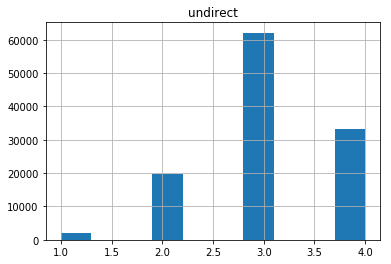

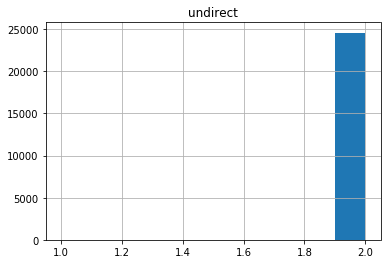

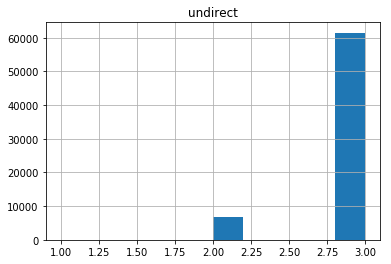

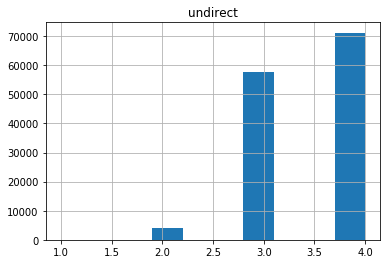

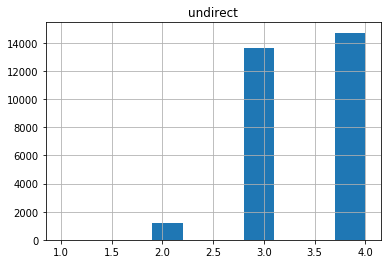

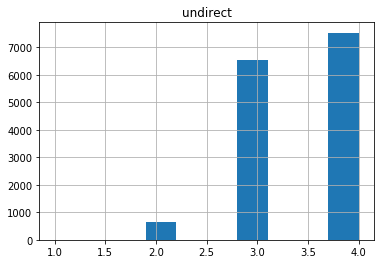

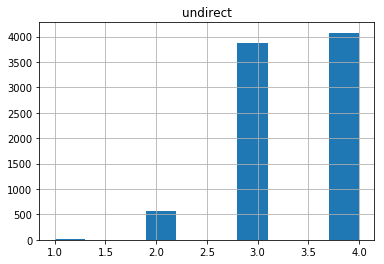

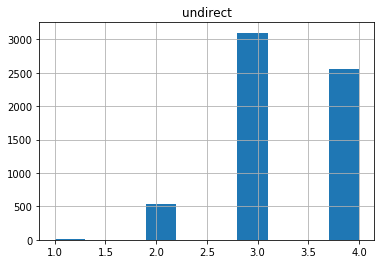

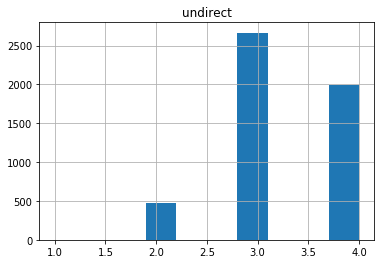

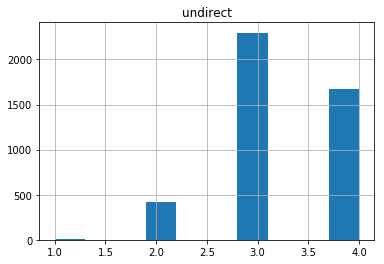

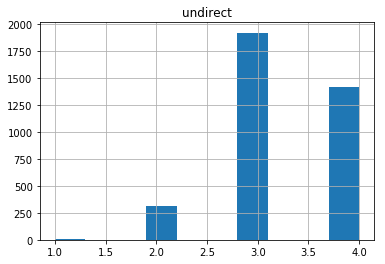

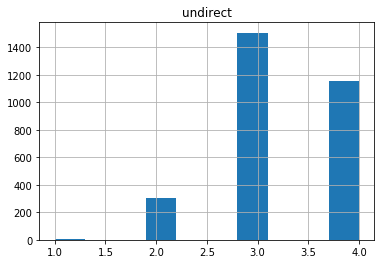

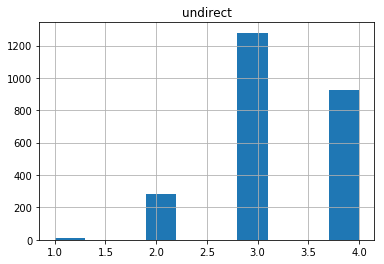

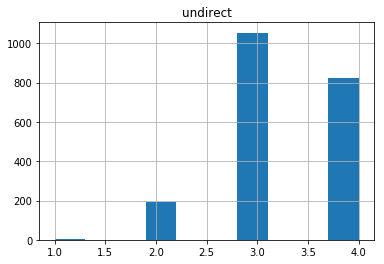

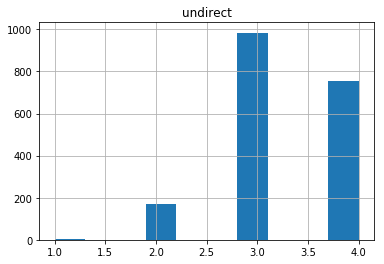

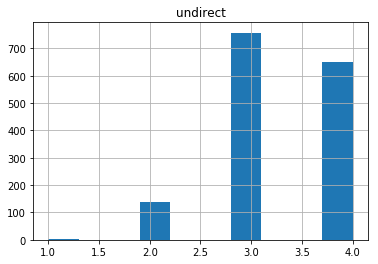

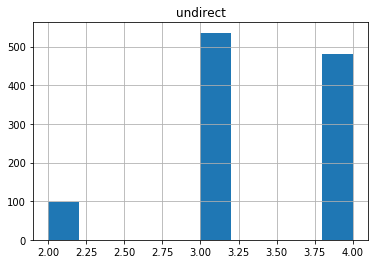

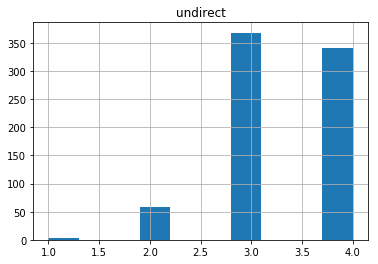

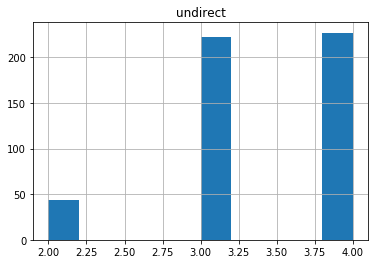

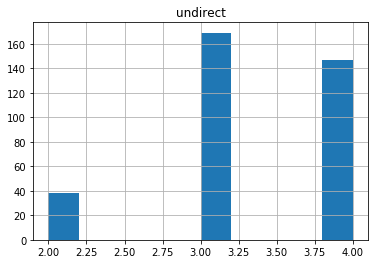

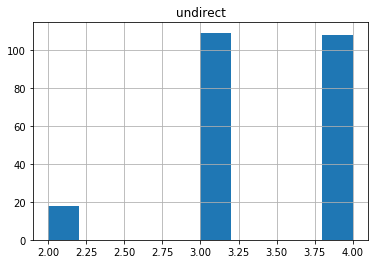

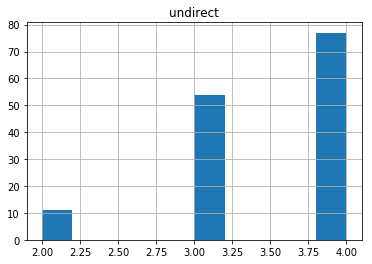

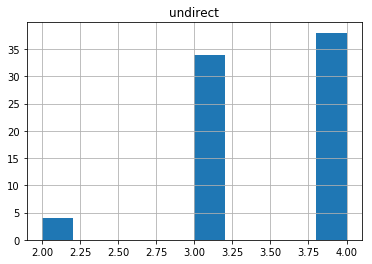

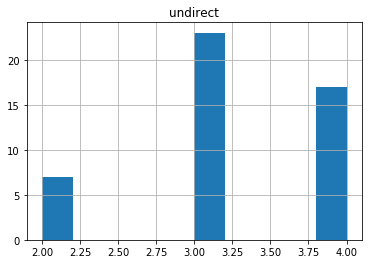

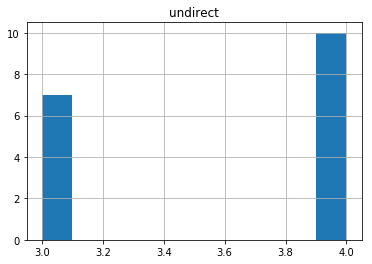

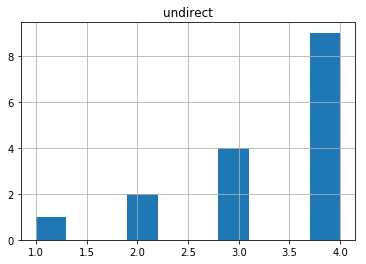

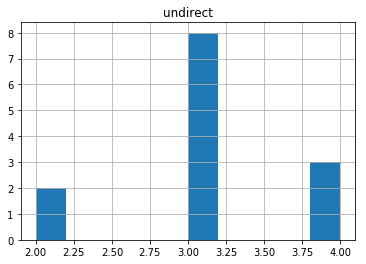

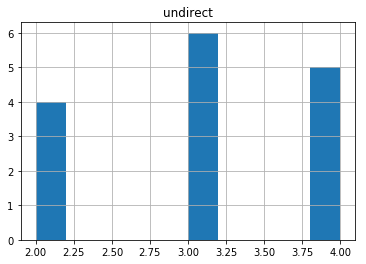

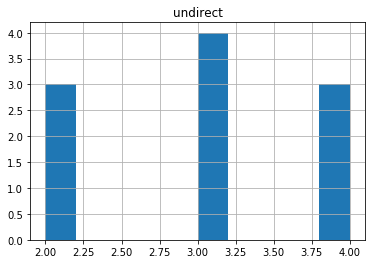

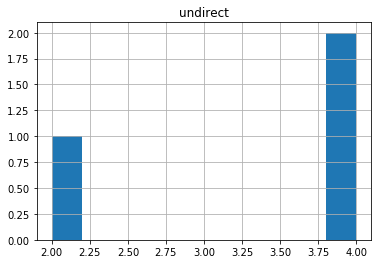

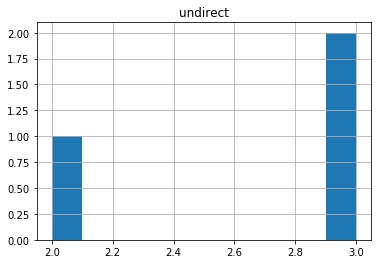

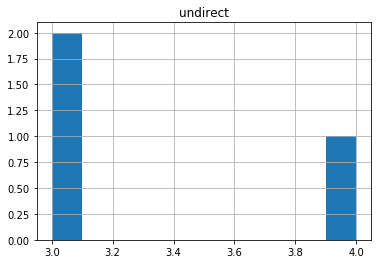

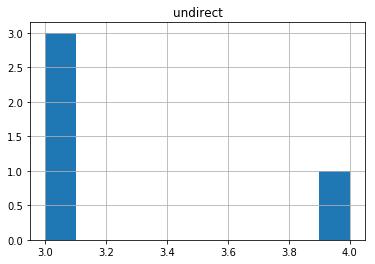

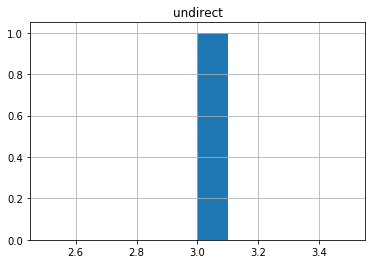

In [104]:
df_val.groupby('direct').hist()

In [27]:
G_test_seen = nx.read_edgelist('t1-test-seen.txt', create_using=nx.DiGraph(), nodetype=int, edgetype=int)
cnt = 0
for i in G_test_seen.edges:
    if i in G_train.edges:
        cnt += 1
cnt

0

In [85]:
len(set(G_train.nodes) | set(G_test.nodes) | set(G_test_seen.nodes))

29624